In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint
from sklearn.linear_model import Ridge
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
# Loading data
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

X.columns = queries

In [3]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries
X = X.iloc[:, 0: 250]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 250)   y shape:  (4383, 1)
train1 X: (3618, 250)  train1 y: (3618, 1)  Test1 X shape: (365, 250)  Test1 y shape: (365, 1)
validation1 X: (400, 250)  validation1 y: (400, 1)
train2 X: (3293, 250)  train2 y: (3293, 1)  Test2 X: (365, 250)  Test2 y: (365, 1)
validation2 X: (360, 250)  validation2 y: (360, 1)


In [4]:
train_size = train1_X.shape[0]
corrs = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs[i] = 0
    else:
        corrs[i] = np.corrcoef(train1_X.iloc[0:train_size,i],train1_y.iloc[0:train_size,0])[0,1]
        
corrs.shape,X.columns.shape,X.columns[0],X.columns[249]

((250, 1), (250,), ('flu',), ('flu incubation',))

In [5]:
def corr_filter(df_X,df_Xval,df_Xtest,corrs,threshold):
    X = df_X.copy()
    X_test = df_Xtest.copy()
    X_val = df_Xval.copy()
    col_corr = set() # Set of all the names of deleted columns
    for i in range(0,250):
            if corrs[i,0] < threshold: 
                #print(X.columns[i])
                colname = df_X.columns[i]
                del X[colname] # deleting the column from the dataset
                del X_test[colname] 
                del X_val[colname]

    return X,X_val,X_test

## Fixing pearson correlation filter r>=0.2

In [6]:
#train1_X0,test1_X0 = corr_filter(train1_X,test1_X,corrs,0.1)
train1_X1,val1_X1,test1_X1 = corr_filter(train1_X,val1_X,test1_X,corrs,0.2)
#train1_X2,test1_X2 = corr_filter(train1_X,test1_X,corrs,0.3)
#train1_X3,test1_X3 = corr_filter(train1_X,test1_X,corrs,0.4)

In [7]:
#print('For correlation filter r>=0.1, we select feature number: ',train1_X0.shape[1])
print('For correlation filter r>=0.2, we select feature number: ',train1_X1.shape[1])
#print('For correlation filter r>=0.3, we select feature number: ',train1_X2.shape[1])
#print('For correlation filter r>=0.4, we select feature number: ',train1_X3.shape[1])

For correlation filter r>=0.2, we select feature number:  149


In [8]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)


# Generalise the function for convinient tuning
def ridge(a,train_X,train_y,test_X,test_y):
    alpha=a
    ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
  
    ri.fit(train_X,train_y)

    y_pred1 = ri.predict(test_X)

    mae1 = mean_absolute_error(test_y, y_pred1)
    #print('The mean absolute error is: ',mae1)

    rmse1 = sqrt(mean_squared_error(test_y, y_pred1))
    #print('The root mean squared error is: ',rmse1)
    
    corr_y = test_y.copy()
    corr_y['y_act'] = test_y
    corr_y['y_pred']= y_pred1
    corr = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]
    #print('The correlation is: ',corr)
    
    return rmse1, mae1,corr
    
    


# scaling and modeling
scaler = MinMaxScaler()
train1_X0_scaled = scaler.fit_transform(train1_X0)
test1_X0_scaled = scaler.transform(test1_x0)

train1_X1_scaled = scaler.fit_transform(train1_X1)
test1_X1_scaled = scaler.transform(test1_x1)

train1_X2_scaled = scaler.fit_transform(train1_X2)
test1_X2_scaled = scaler.transform(test1_x2)

train1_X3_scaled = scaler.fit_transform(train1_X3)
test1_X3_scaled = scaler.transform(test1_x3)


para = [10]
para_l=[0.3]
print('For correlation filter r>=0.1, 310 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X0,train1_y,test1_X0,test1_y))

In [9]:
print(train1_X1.shape,val1_X1.shape)
train3_X = train1_X1.append(val1_X1)
train3_y = train1_y.append(val1_y)
train3_X.shape,train3_y.shape

(3618, 149) (400, 149)


((4018, 149), (4018, 1))

In [12]:

para = np.arange(0.01, 100000000, 100000)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train1_X1,train1_y,val1_X1,val1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')
        

alpha: 0.01
Best RMSE is updated! 
The mean absolute error is:  22.368644885239473
The root mean squared error is:  45.367388318255685
The correlation is:  0.7429302790649935
----------------------------------------
alpha: 100000.01
Best RMSE is updated! 
The mean absolute error is:  22.505635612326536
The root mean squared error is:  44.99154778046597
The correlation is:  0.7740398615327843
----------------------------------------
alpha: 200000.01
Best RMSE is updated! 
The mean absolute error is:  22.46324850433762
The root mean squared error is:  44.40903625404366
The correlation is:  0.793248416956118
----------------------------------------
alpha: 300000.01
Best RMSE is updated! 
The mean absolute error is:  22.419279416724667
The root mean squared error is:  43.96598937088599
The correlation is:  0.8068864156129214
----------------------------------------
alpha: 400000.01
Best RMSE is updated! 
The mean absolute error is:  22.38009535883411
The root mean squared error is:  43.621

Best RMSE is updated! 
The mean absolute error is:  21.097847229744083
The root mean squared error is:  38.89727914876763
The correlation is:  0.8889305076881779
----------------------------------------
alpha: 5600000.01
Best RMSE is updated! 
The mean absolute error is:  21.081481959321515
The root mean squared error is:  38.85066608970924
The correlation is:  0.8891558477615971
----------------------------------------
alpha: 5700000.01
Best RMSE is updated! 
The mean absolute error is:  21.06539890921084
The root mean squared error is:  38.80487269521547
The correlation is:  0.8893729544195987
----------------------------------------
alpha: 5800000.01
Best RMSE is updated! 
The mean absolute error is:  21.04959364164703
The root mean squared error is:  38.75988150692023
The correlation is:  0.8895821723938637
----------------------------------------
alpha: 5900000.01
Best RMSE is updated! 
The mean absolute error is:  21.034061751458548
The root mean squared error is:  38.71567556245

Best RMSE is updated! 
The mean absolute error is:  20.659574048779085
The root mean squared error is:  37.634309509683995
The correlation is:  0.8935295712751476
----------------------------------------
alpha: 9200000.01
Best RMSE is updated! 
The mean absolute error is:  20.65099193783815
The root mean squared error is:  37.60888272853699
The correlation is:  0.8935888730274629
----------------------------------------
alpha: 9300000.01
Best RMSE is updated! 
The mean absolute error is:  20.642564183907638
The root mean squared error is:  37.58386288455485
The correlation is:  0.8936457718529556
----------------------------------------
alpha: 9400000.01
Best RMSE is updated! 
The mean absolute error is:  20.634288256886588
The root mean squared error is:  37.55924284916625
The correlation is:  0.8937003336443632
----------------------------------------
alpha: 9500000.01
Best RMSE is updated! 
The mean absolute error is:  20.62616167327677
The root mean squared error is:  37.5350156509

Best RMSE is updated! 
The mean absolute error is:  20.4545251025928
The root mean squared error is:  36.9920515814661
The correlation is:  0.8944945194227149
----------------------------------------
alpha: 12400000.01
Best RMSE is updated! 
The mean absolute error is:  20.450002198234483
The root mean squared error is:  36.97676313209882
The correlation is:  0.8945008261860468
----------------------------------------
alpha: 12500000.01
Best RMSE is updated! 
The mean absolute error is:  20.445571372777987
The root mean squared error is:  36.96171465782069
The correlation is:  0.8945060431004802
----------------------------------------
alpha: 12600000.01
Best RMSE is updated! 
The mean absolute error is:  20.441231232435868
The root mean squared error is:  36.94690249895731
The correlation is:  0.8945101939135851
----------------------------------------
alpha: 12700000.01
Best RMSE is updated! 
The mean absolute error is:  20.43698040830126
The root mean squared error is:  36.932323066

Best RMSE is updated! 
The mean absolute error is:  20.347192130984975
The root mean squared error is:  36.596806807491724
The correlation is:  0.8942344812342172
----------------------------------------
alpha: 15700000.01
Best RMSE is updated! 
The mean absolute error is:  20.345089384708455
The root mean squared error is:  36.58783131768383
The correlation is:  0.8942145339981513
----------------------------------------
alpha: 15800000.01
Best RMSE is updated! 
The mean absolute error is:  20.343043503236707
The root mean squared error is:  36.579004789812906
The correlation is:  0.8941940283090445
----------------------------------------
alpha: 15900000.01
Best RMSE is updated! 
The mean absolute error is:  20.341053698275772
The root mean squared error is:  36.57032521749032
The correlation is:  0.8941729745073611
----------------------------------------
alpha: 16000000.01
Best RMSE is updated! 
The mean absolute error is:  20.339119194395256
The root mean squared error is:  36.561

Best RMSE is updated! 
The mean absolute error is:  20.301049079567175
The root mean squared error is:  36.341241025540256
The correlation is:  0.893121242677442
----------------------------------------
alpha: 19600000.01
Best RMSE is updated! 
The mean absolute error is:  20.300679883408637
The root mean squared error is:  36.33684897738191
The correlation is:  0.8930854846080681
----------------------------------------
alpha: 19700000.01
Best RMSE is updated! 
The mean absolute error is:  20.300344458999056
The root mean squared error is:  36.33254753247444
The correlation is:  0.8930494443689747
----------------------------------------
alpha: 19800000.01
Best RMSE is updated! 
The mean absolute error is:  20.300042376749424
The root mean squared error is:  36.32833561156841
The correlation is:  0.8930131265815223
----------------------------------------
alpha: 19900000.01
Best RMSE is updated! 
The mean absolute error is:  20.299773213330383
The root mean squared error is:  36.32421

Best RMSE is updated! 
The mean absolute error is:  20.305520012996585
The root mean squared error is:  36.236944966210054
The correlation is:  0.8917713272404303
----------------------------------------
alpha: 23000000.01
Best RMSE is updated! 
The mean absolute error is:  20.3061132402864
The root mean squared error is:  36.23511112619184
The correlation is:  0.8917281325187841
----------------------------------------
alpha: 23100000.01
Best RMSE is updated! 
The mean absolute error is:  20.30672853416562
The root mean squared error is:  36.2333386270588
The correlation is:  0.8916847742704985
----------------------------------------
alpha: 23200000.01
Best RMSE is updated! 
The mean absolute error is:  20.307365628234866
The root mean squared error is:  36.231626798912906
The correlation is:  0.8916412550443925
----------------------------------------
alpha: 23300000.01
Best RMSE is updated! 
The mean absolute error is:  20.308024259635566
The root mean squared error is:  36.2299749

alpha: 26700000.01
alpha: 26800000.01
alpha: 26900000.01
alpha: 27000000.01
alpha: 27100000.01
alpha: 27200000.01
alpha: 27300000.01
alpha: 27400000.01
alpha: 27500000.01
alpha: 27600000.01
alpha: 27700000.01
alpha: 27800000.01
alpha: 27900000.01
alpha: 28000000.01
alpha: 28100000.01
alpha: 28200000.01
alpha: 28300000.01
alpha: 28400000.01
alpha: 28500000.01
alpha: 28600000.01
alpha: 28700000.01
alpha: 28800000.01
alpha: 28900000.01
alpha: 29000000.01
alpha: 29100000.01
alpha: 29200000.01
alpha: 29300000.01
alpha: 29400000.01
alpha: 29500000.01
alpha: 29600000.01
alpha: 29700000.01
alpha: 29800000.01
alpha: 29900000.01
alpha: 30000000.01
alpha: 30100000.01
alpha: 30200000.01
alpha: 30300000.01
alpha: 30400000.01
alpha: 30500000.01
alpha: 30600000.01
alpha: 30700000.01
alpha: 30800000.01
alpha: 30900000.01
alpha: 31000000.01
alpha: 31100000.01
alpha: 31200000.01
alpha: 31300000.01
alpha: 31400000.01
alpha: 31500000.01
alpha: 31600000.01
alpha: 31700000.01
alpha: 31800000.01
alpha: 31900

alpha: 70700000.01
alpha: 70800000.01
alpha: 70900000.01
alpha: 71000000.01
alpha: 71100000.01
alpha: 71200000.01
alpha: 71300000.01
alpha: 71400000.01
alpha: 71500000.01
alpha: 71600000.01
alpha: 71700000.01
alpha: 71800000.01
alpha: 71900000.01
alpha: 72000000.01
alpha: 72100000.01
alpha: 72200000.01
alpha: 72300000.01
alpha: 72400000.01
alpha: 72500000.01
alpha: 72600000.01
alpha: 72700000.01
alpha: 72800000.01
alpha: 72900000.01
alpha: 73000000.01
alpha: 73100000.01
alpha: 73200000.01
alpha: 73300000.01
alpha: 73400000.01
alpha: 73500000.01
alpha: 73600000.01
alpha: 73700000.01
alpha: 73800000.01
alpha: 73900000.01
alpha: 74000000.01
alpha: 74100000.01
alpha: 74200000.01
alpha: 74300000.01
alpha: 74400000.01
alpha: 74500000.01
alpha: 74600000.01
alpha: 74700000.01
alpha: 74800000.01
alpha: 74900000.01
alpha: 75000000.01
alpha: 75100000.01
alpha: 75200000.01
alpha: 75300000.01
alpha: 75400000.01
alpha: 75500000.01
alpha: 75600000.01
alpha: 75700000.01
alpha: 75800000.01
alpha: 75900

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 150 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X2,train1_y,test1_X2,test1_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 103 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X3,train1_y,test1_X3,test1_y))

In [13]:
para =[26600000,0]
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train3_X,train3_y,test1_X1,test1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 26600000
Best RMSE is updated! 
The mean absolute error is:  3.2947609364610586
The root mean squared error is:  3.717536119182588
The correlation is:  0.9020508472082133
----------------------------------------
alpha: 0
Best RMSE is updated! 
The mean absolute error is:  2.862250573858442
The root mean squared error is:  3.491948242954019
The correlation is:  0.9130835230524864
----------------------------------------


In [14]:
alpha=2350000 
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train3_X,train3_y)

y_pred1 = ri.predict(test1_X1)

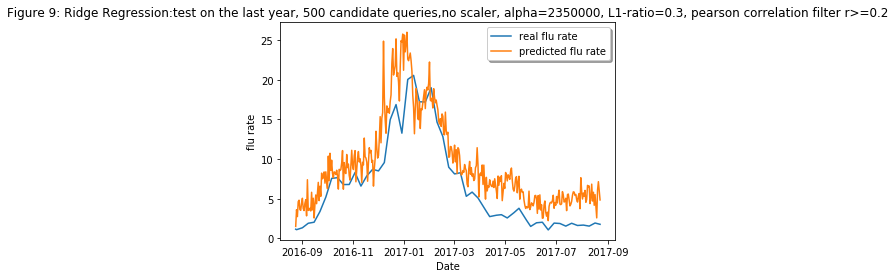

In [15]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],y_pred1,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 9: Ridge Regression:test on the last year, 500 candidate queries,no scaler, alpha=2350000, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

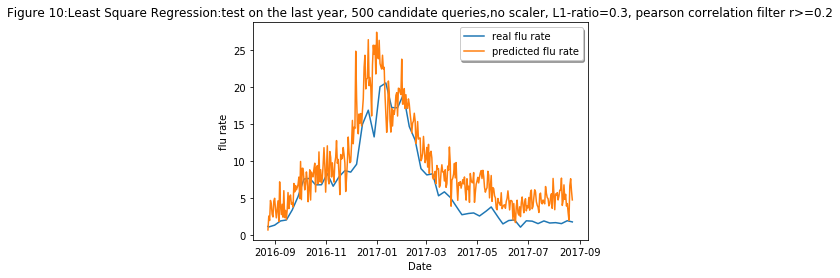

In [16]:
alpha=0
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train3_X,train3_y)

y_pred1 = ri.predict(test1_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],y_pred1,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 10:Least Square Regression:test on the last year, 500 candidate queries,no scaler, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

## For the last 2 years as the testing set

In [20]:
train_size2 = train2_X.shape[0]
corrs2 = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs2[i] = 0
    else:
        corrs2[i] = np.corrcoef(train2_X.iloc[0:train_size2,i],train2_y.iloc[0:train_size2,0])[0,1]
        
corrs2.shape,X.columns.shape,X.columns[0],X.columns[249]

((250, 1), (250,), ('flu',), ('flu incubation',))

In [21]:
#train2_X0,test2_X0 = corr_filter(train2_X,test2_X,corrs2,0.1)
train2_X1,val2_X1,test2_X1 = corr_filter(train2_X,val2_X,test2_X,corrs2,0.2)
#train2_X2,test2_X2 = corr_filter(train2_X,test2_X,corrs2,0.3)
#train2_X3,test2_X3 = corr_filter(train2_X,test2_X,corrs2,0.4)

In [22]:
#print('For correlation filter r>0.1, we select feature number: ',train2_X0.shape[1])
print('For correlation filter r>0.2, we select feature number: ',train2_X1.shape[1])
#print('For correlation filter r>0.3, we select feature number: ',train2_X2.shape[1])
#print('For correlation filter r>0.4, we select feature number: ',train2_X3.shape[1])

For correlation filter r>0.2, we select feature number:  163


# scaling and modeling
scaler = MinMaxScaler()
train2_X0_scaled = scaler.fit_transform(train2_X0)
test2_X0_scaled = scaler.transform(test2_X0)

train2_X1_scaled = scaler.fit_transform(train2_X1)
test2_X1_scaled = scaler.transform(test2_X1)

train2_X2_scaled = scaler.fit_transform(train2_X2)
test2_X2_scaled = scaler.transform(test2_X2)

train2_X3_scaled = scaler.fit_transform(train2_X3)
test2_X3_scaled = scaler.transform(test2_X3)


para = range(1,100)
para = np.arange(0.01, 10.0, 0.01)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train1_X1,train1_y,val1_X1,val1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

In [23]:
print(train2_X1.shape,val2_X1.shape)
train4_X = train2_X1.append(val2_X1)
train4_y = train2_y.append(val2_y)
train4_X.shape,train4_y.shape

(3293, 163) (360, 163)


((3653, 163), (3653, 1))

In [24]:

para =np.arange(0, 10000000, 10000)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train2_X1,train2_y,val2_X1,val2_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 0
Best RMSE is updated! 
The mean absolute error is:  4.239781473075823
The root mean squared error is:  7.787613238297006
The correlation is:  0.5012419369221024
----------------------------------------
alpha: 10000
Best RMSE is updated! 
The mean absolute error is:  4.227323842932079
The root mean squared error is:  7.755310194012339
The correlation is:  0.5024938604218494
----------------------------------------
alpha: 20000
Best RMSE is updated! 
The mean absolute error is:  4.214781714004223
The root mean squared error is:  7.722449817480155
The correlation is:  0.5038361936847061
----------------------------------------
alpha: 30000
Best RMSE is updated! 
The mean absolute error is:  4.2021794430640975
The root mean squared error is:  7.689702044263205
The correlation is:  0.5052233773864793
----------------------------------------
alpha: 40000
Best RMSE is updated! 
The mean absolute error is:  4.189781449731854
The root mean squared error is:  7.657430227457274
The corre

Best RMSE is updated! 
The mean absolute error is:  3.956481395993203
The root mean squared error is:  6.910780883844588
The correlation is:  0.5455672193947128
----------------------------------------
alpha: 400000
Best RMSE is updated! 
The mean absolute error is:  3.952378364736771
The root mean squared error is:  6.896539753458653
The correlation is:  0.5464279796454373
----------------------------------------
alpha: 410000
Best RMSE is updated! 
The mean absolute error is:  3.948324835349304
The root mean squared error is:  6.8825470176788
The correlation is:  0.5472788009101689
----------------------------------------
alpha: 420000
Best RMSE is updated! 
The mean absolute error is:  3.9443524582630958
The root mean squared error is:  6.868795871202168
The correlation is:  0.5481198987348583
----------------------------------------
alpha: 430000
Best RMSE is updated! 
The mean absolute error is:  3.9404732313841673
The root mean squared error is:  6.855279794543389
The correlation

Best RMSE is updated! 
The mean absolute error is:  3.8130499317122846
The root mean squared error is:  6.412602402777577
The correlation is:  0.5793861645908943
----------------------------------------
alpha: 900000
Best RMSE is updated! 
The mean absolute error is:  3.810962049106638
The root mean squared error is:  6.405763664541119
The correlation is:  0.5799157210531596
----------------------------------------
alpha: 910000
Best RMSE is updated! 
The mean absolute error is:  3.8088904025114605
The root mean squared error is:  6.399010840824129
The correlation is:  0.5804408200437157
----------------------------------------
alpha: 920000
Best RMSE is updated! 
The mean absolute error is:  3.806834791201435
The root mean squared error is:  6.39234250302632
The correlation is:  0.5809615148637868
----------------------------------------
alpha: 930000
Best RMSE is updated! 
The mean absolute error is:  3.8047950173487544
The root mean squared error is:  6.385757256277546
The correlati

Best RMSE is updated! 
The mean absolute error is:  3.73962575275375
The root mean squared error is:  6.186004055958869
The correlation is:  0.5982992686137812
----------------------------------------
alpha: 1320000
Best RMSE is updated! 
The mean absolute error is:  3.7381765339436446
The root mean squared error is:  6.181840516399139
The correlation is:  0.5986775338063829
----------------------------------------
alpha: 1330000
Best RMSE is updated! 
The mean absolute error is:  3.7367365488465327
The root mean squared error is:  6.177723251643863
The correlation is:  0.5990528921368506
----------------------------------------
alpha: 1340000
Best RMSE is updated! 
The mean absolute error is:  3.7353057004085093
The root mean squared error is:  6.173651665040087
The correlation is:  0.5994253684651082
----------------------------------------
alpha: 1350000
Best RMSE is updated! 
The mean absolute error is:  3.7338838930403155
The root mean squared error is:  6.169625170627778
The corr

Best RMSE is updated! 
The mean absolute error is:  3.689663488046223
The root mean squared error is:  6.05049733461773
The correlation is:  0.6113780430705439
----------------------------------------
alpha: 1720000
Best RMSE is updated! 
The mean absolute error is:  3.6885770481291362
The root mean squared error is:  6.047806015586958
The correlation is:  0.6116562988022337
----------------------------------------
alpha: 1730000
Best RMSE is updated! 
The mean absolute error is:  3.6874964767017264
The root mean squared error is:  6.045143489941698
The correlation is:  0.6119324110539093
----------------------------------------
alpha: 1740000
Best RMSE is updated! 
The mean absolute error is:  3.686421724103103
The root mean squared error is:  6.04250944661574
The correlation is:  0.6122063943003317
----------------------------------------
alpha: 1750000
Best RMSE is updated! 
The mean absolute error is:  3.6853527413114877
The root mean squared error is:  6.039903579059256
The correl

Best RMSE is updated! 
The mean absolute error is:  3.657820437191921
The root mean squared error is:  5.971608589113466
The correlation is:  0.6199285226659957
----------------------------------------
alpha: 2070000
Best RMSE is updated! 
The mean absolute error is:  3.657024998918554
The root mean squared error is:  5.969765554265412
The correlation is:  0.6201394187366001
----------------------------------------
alpha: 2080000
Best RMSE is updated! 
The mean absolute error is:  3.656233486116867
The root mean squared error is:  5.967942636359682
The correlation is:  0.6203485957714597
----------------------------------------
alpha: 2090000
Best RMSE is updated! 
The mean absolute error is:  3.655445869903539
The root mean squared error is:  5.9661396417386054
The correlation is:  0.6205560638708217
----------------------------------------
alpha: 2100000
Best RMSE is updated! 
The mean absolute error is:  3.6546621217318767
The root mean squared error is:  5.964356379151537
The corre

Best RMSE is updated! 
The mean absolute error is:  3.6227674449219482
The root mean squared error is:  5.898729070307829
The correlation is:  0.6288176005322652
----------------------------------------
alpha: 2590000
Best RMSE is updated! 
The mean absolute error is:  3.6221870123547655
The root mean squared error is:  5.89771958175684
The correlation is:  0.6289508233477799
----------------------------------------
alpha: 2600000
Best RMSE is updated! 
The mean absolute error is:  3.6216091836633604
The root mean squared error is:  5.89672263516312
The correlation is:  0.6290827575370249
----------------------------------------
alpha: 2610000
Best RMSE is updated! 
The mean absolute error is:  3.621033943461624
The root mean squared error is:  5.895738123327524
The correlation is:  0.6292134098919425
----------------------------------------
alpha: 2620000
Best RMSE is updated! 
The mean absolute error is:  3.620462272436636
The root mean squared error is:  5.894765940155455
The correl

Best RMSE is updated! 
The mean absolute error is:  3.605566456713217
The root mean squared error is:  5.8721514961105585
The correlation is:  0.6324737838773694
----------------------------------------
alpha: 2910000
Best RMSE is updated! 
The mean absolute error is:  3.605068509404244
The root mean squared error is:  5.871495172806152
The correlation is:  0.6325689394375812
----------------------------------------
alpha: 2920000
Best RMSE is updated! 
The mean absolute error is:  3.6045798738485093
The root mean squared error is:  5.8708484437001776
The correlation is:  0.632663004287109
----------------------------------------
alpha: 2930000
Best RMSE is updated! 
The mean absolute error is:  3.6040933732318976
The root mean squared error is:  5.870211230684473
The correlation is:  0.6327559840346757
----------------------------------------
alpha: 2940000
Best RMSE is updated! 
The mean absolute error is:  3.60360899628253
The root mean squared error is:  5.869583456385441
The corre

alpha: 3250000
Best RMSE is updated! 
The mean absolute error is:  3.5896000372030574
The root mean squared error is:  5.854413287484749
The correlation is:  0.6351904278840839
----------------------------------------
alpha: 3260000
Best RMSE is updated! 
The mean absolute error is:  3.589179064744116
The root mean squared error is:  5.854050669609934
The correlation is:  0.6352505566147133
----------------------------------------
alpha: 3270000
Best RMSE is updated! 
The mean absolute error is:  3.5887598863375754
The root mean squared error is:  5.853695297534959
The correlation is:  0.6353097741756043
----------------------------------------
alpha: 3280000
Best RMSE is updated! 
The mean absolute error is:  3.588342493494555
The root mean squared error is:  5.853347114365187
The correlation is:  0.6353680852371036
----------------------------------------
alpha: 3290000
Best RMSE is updated! 
The mean absolute error is:  3.587926877790965
The root mean squared error is:  5.8530060636

Best RMSE is updated! 
The mean absolute error is:  3.57595001429907
The root mean squared error is:  5.845684675396172
The correlation is:  0.6367821980027147
----------------------------------------
alpha: 3610000
Best RMSE is updated! 
The mean absolute error is:  3.575631992042026
The root mean squared error is:  5.845544771051654
The correlation is:  0.6368130717723037
----------------------------------------
alpha: 3620000
Best RMSE is updated! 
The mean absolute error is:  3.5753153358366174
The root mean squared error is:  5.845410382553676
The correlation is:  0.6368431851002951
----------------------------------------
alpha: 3630000
Best RMSE is updated! 
The mean absolute error is:  3.5750000398065556
The root mean squared error is:  5.8452814674852345
The correlation is:  0.6368725419365
----------------------------------------
alpha: 3640000
Best RMSE is updated! 
The mean absolute error is:  3.57468609811539
The root mean squared error is:  5.845157983770837
The correlati

alpha: 4260000
alpha: 4270000
alpha: 4280000
alpha: 4290000
alpha: 4300000
alpha: 4310000
alpha: 4320000
alpha: 4330000
alpha: 4340000
alpha: 4350000
alpha: 4360000
alpha: 4370000
alpha: 4380000
alpha: 4390000
alpha: 4400000
alpha: 4410000
alpha: 4420000
alpha: 4430000
alpha: 4440000
alpha: 4450000
alpha: 4460000
alpha: 4470000
alpha: 4480000
alpha: 4490000
alpha: 4500000
alpha: 4510000
alpha: 4520000
alpha: 4530000
alpha: 4540000
alpha: 4550000
alpha: 4560000
alpha: 4570000
alpha: 4580000
alpha: 4590000
alpha: 4600000
alpha: 4610000
alpha: 4620000
alpha: 4630000
alpha: 4640000
alpha: 4650000
alpha: 4660000
alpha: 4670000
alpha: 4680000
alpha: 4690000
alpha: 4700000
alpha: 4710000
alpha: 4720000
alpha: 4730000
alpha: 4740000
alpha: 4750000
alpha: 4760000
alpha: 4770000
alpha: 4780000
alpha: 4790000
alpha: 4800000
alpha: 4810000
alpha: 4820000
alpha: 4830000
alpha: 4840000
alpha: 4850000
alpha: 4860000
alpha: 4870000
alpha: 4880000
alpha: 4890000
alpha: 4900000
alpha: 4910000
alpha: 492

alpha: 9890000
alpha: 9900000
alpha: 9910000
alpha: 9920000
alpha: 9930000
alpha: 9940000
alpha: 9950000
alpha: 9960000
alpha: 9970000
alpha: 9980000
alpha: 9990000


para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 154 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X2,train2_y,test2_X2,test2_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 105 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X3,train2_y,test2_X3,test2_y))

In [25]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [3890000,0]
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train4_X,train4_y,test2_X1,test2_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 3890000
Best RMSE is updated! 
The mean absolute error is:  2.6429663424020466
The root mean squared error is:  3.2451394749860594
The correlation is:  0.913692018799654
----------------------------------------
alpha: 0
Best RMSE is updated! 
The mean absolute error is:  2.4384173692675932
The root mean squared error is:  3.1617586520118084
The correlation is:  0.9045851596642489
----------------------------------------


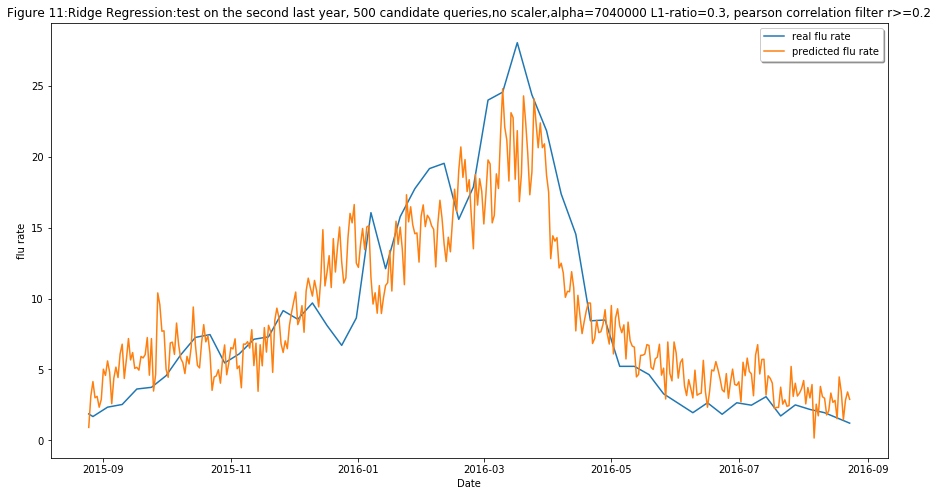

In [29]:
alpha=704000
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train4_X,train4_y)

y_pred2 = ri.predict(test2_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],y_pred2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 11:Ridge Regression:test on the second last year, 500 candidate queries,no scaler,alpha=7040000 L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

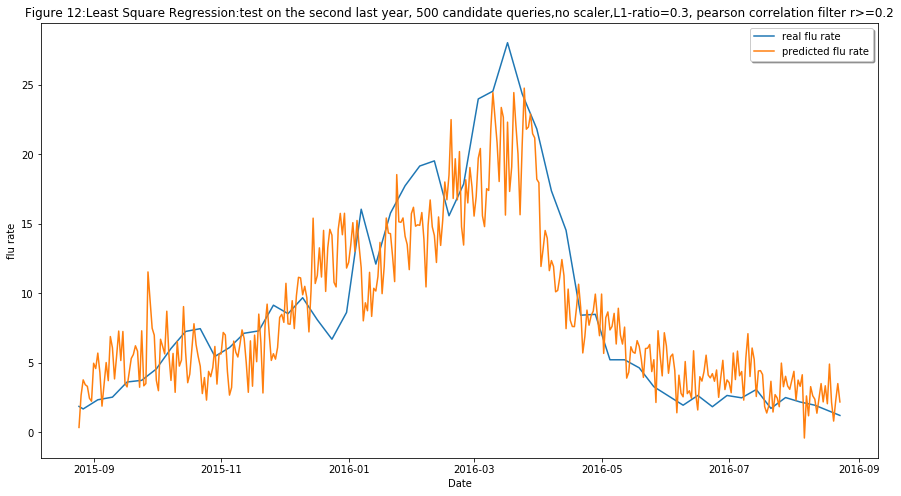

In [31]:
alpha=0
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train4_X,train4_y)

y_pred2 = ri.predict(test2_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],y_pred2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 12:Least Square Regression:test on the second last year, 500 candidate queries,no scaler,L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()